<p style="font-size:32px;text-align:center"> <b>Social network Graph Link Prediction - Facebook Challenge</b> </p>

### Problem Statment:

* To improve the model performance.

### Approach

* Lets Add another feature called  Preferential Attachment  with followers and followees data of vertex. 
* Lets try adding a feature called svd_dot.

### References :

* https://storage.googleapis.com/kaggle-forum-message-attachments/2594/supervised_link_prediction.pdf
* http://be.amazd.com/link-prediction/

In [12]:
#Importing Libraries
# please do go through this python notebook: 
import warnings
warnings.filterwarnings("ignore")

import csv
import pandas as pd#pandas to create small dataframes 
import datetime #Convert to unix time
import time #Convert to unix time
# if numpy is not installed already : pip3 install numpy
import numpy as np#Do aritmetic operations on arrays
# matplotlib: used to plot graphs
import matplotlib
import matplotlib.pylab as plt
import seaborn as sns#Plots
from matplotlib import rcParams#Size of plots  
from sklearn.cluster import MiniBatchKMeans, KMeans#Clustering
import math
import pickle
import os
# to install xgboost: pip3 install xgboost
import xgboost as xgb

import warnings
import networkx as nx
import pdb
import pickle
from pandas import HDFStore,DataFrame
from pandas import read_hdf
from scipy.sparse.linalg import svds, eigs
import gc
from tqdm import tqdm
from sklearn.metrics import f1_score

## Reading data:

In [13]:
#reading
from pandas import read_hdf
df_final_train = read_hdf('data.h5', 'train_df',mode='r')
df_final_test = read_hdf('data.h5', 'test_df',mode='r')

In [15]:
df_final_train.columns

Index(['source_node', 'destination_node', 'indicator_link',
       'jaccard_followers', 'jaccard_followees', 'cosine_followers',
       'cosine_followees', 'num_followers_s', 'num_followers_d',
       'num_followees_s', 'num_followees_d', 'inter_followers',
       'inter_followees', 'adar_index', 'follows_back', 'same_comp',
       'shortest_path', 'weight_in', 'weight_out', 'weight_f1', 'weight_f2',
       'weight_f3', 'weight_f4', 'page_rank_s', 'page_rank_d', 'katz_s',
       'katz_d', 'hubs_s', 'hubs_d', 'authorities_s', 'authorities_d',
       'svd_u_s_1', 'svd_u_s_2', 'svd_u_s_3', 'svd_u_s_4', 'svd_u_s_5',
       'svd_u_s_6', 'svd_u_d_1', 'svd_u_d_2', 'svd_u_d_3', 'svd_u_d_4',
       'svd_u_d_5', 'svd_u_d_6', 'svd_v_s_1', 'svd_v_s_2', 'svd_v_s_3',
       'svd_v_s_4', 'svd_v_s_5', 'svd_v_s_6', 'svd_v_d_1', 'svd_v_d_2',
       'svd_v_d_3', 'svd_v_d_4', 'svd_v_d_5', 'svd_v_d_6'],
      dtype='object')

### Adding Preferential Attachment:

In [16]:
df_final_train['prefer_attach_followers']=df_final_train['num_followers_s'] * df_final_train['num_followers_d']
df_final_test['prefer_attach_followers']=df_final_test['num_followers_s']   * df_final_test['num_followers_d']

df_final_train['prefer_attach_followees']=df_final_train['num_followees_s'] * df_final_train['num_followees_d']
df_final_test['prefer_attach_followees']=df_final_test['num_followees_s'] * df_final_test['num_followees_d']

### Adding SVD_DOT:

In [19]:
df_final_train['svd_dot_u']=df_final_train['svd_u_s_1'] * df_final_train['svd_u_d_1'] +\
                          df_final_train['svd_u_s_2'] * df_final_train['svd_u_d_2'] +\
                          df_final_train['svd_u_s_3'] * df_final_train['svd_u_d_3'] +\
                          df_final_train['svd_u_s_4'] * df_final_train['svd_u_d_4'] +\
                          df_final_train['svd_u_s_5'] * df_final_train['svd_u_d_5'] +\
                          df_final_train['svd_u_s_6'] * df_final_train['svd_u_d_6'] 
                          

df_final_train['svd_dot_v']=df_final_train['svd_v_s_1'] * df_final_train['svd_v_d_1'] +\
                          df_final_train['svd_v_s_2'] * df_final_train['svd_v_d_2'] +\
                          df_final_train['svd_v_s_3'] * df_final_train['svd_v_d_3'] +\
                          df_final_train['svd_v_s_4'] * df_final_train['svd_v_d_4'] +\
                          df_final_train['svd_v_s_5'] * df_final_train['svd_v_d_5'] +\
                          df_final_train['svd_v_s_6'] * df_final_train['svd_v_d_6']           

In [20]:
df_final_test['svd_dot_u']= df_final_test['svd_u_s_1'] * df_final_test['svd_u_d_1'] +\
                          df_final_test['svd_u_s_2'] * df_final_test['svd_u_d_2'] +\
                          df_final_test['svd_u_s_3'] * df_final_test['svd_u_d_3'] +\
                          df_final_test['svd_u_s_4'] * df_final_test['svd_u_d_4'] +\
                          df_final_test['svd_u_s_5'] * df_final_test['svd_u_d_5'] +\
                          df_final_test['svd_u_s_6'] * df_final_test['svd_u_d_6'] 

df_final_test['svd_dot_v']=df_final_test['svd_v_s_1'] * df_final_test['svd_v_d_1'] +\
                          df_final_test['svd_v_s_2'] * df_final_test['svd_v_d_2'] +\
                          df_final_test['svd_v_s_3'] * df_final_test['svd_v_d_3'] +\
                          df_final_test['svd_v_s_4'] * df_final_test['svd_v_d_4'] +\
                          df_final_test['svd_v_s_5'] * df_final_test['svd_v_d_5'] +\
                          df_final_test['svd_v_s_6'] * df_final_test['svd_v_d_6']           

In [21]:
df_final_train.columns

Index(['jaccard_followers', 'jaccard_followees', 'cosine_followers',
       'cosine_followees', 'num_followers_s', 'num_followers_d',
       'num_followees_s', 'num_followees_d', 'inter_followers',
       'inter_followees', 'adar_index', 'follows_back', 'same_comp',
       'shortest_path', 'weight_in', 'weight_out', 'weight_f1', 'weight_f2',
       'weight_f3', 'weight_f4', 'page_rank_s', 'page_rank_d', 'katz_s',
       'katz_d', 'hubs_s', 'hubs_d', 'authorities_s', 'authorities_d',
       'svd_u_s_1', 'svd_u_s_2', 'svd_u_s_3', 'svd_u_s_4', 'svd_u_s_5',
       'svd_u_s_6', 'svd_u_d_1', 'svd_u_d_2', 'svd_u_d_3', 'svd_u_d_4',
       'svd_u_d_5', 'svd_u_d_6', 'svd_v_s_1', 'svd_v_s_2', 'svd_v_s_3',
       'svd_v_s_4', 'svd_v_s_5', 'svd_v_s_6', 'svd_v_d_1', 'svd_v_d_2',
       'svd_v_d_3', 'svd_v_d_4', 'svd_v_d_5', 'svd_v_d_6',
       'prefer_attach_followers', 'prefer_attach_followees', 'svd_dot_u',
       'svd_dot_v'],
      dtype='object')

In [0]:
y_train = df_final_train.indicator_link
y_test = df_final_test.indicator_link

In [0]:
df_final_train.drop(['source_node', 'destination_node','indicator_link'],axis=1,inplace=True)
df_final_test.drop(['source_node', 'destination_node','indicator_link'],axis=1,inplace=True)

Estimators =  10 Train Score 0.9308385308385309 test Score 0.9244727280545223
Estimators =  50 Train Score 0.9734898135446831 test Score 0.929201470807031
Estimators =  100 Train Score 0.9783164819100988 test Score 0.9270272579680424
Estimators =  250 Train Score 0.9873381934207072 test Score 0.9245295137773781
Estimators =  450 Train Score 0.9951201843262333 test Score 0.9205393432399304


Text(0.5, 1.0, 'Estimators vs score at depth of 5')

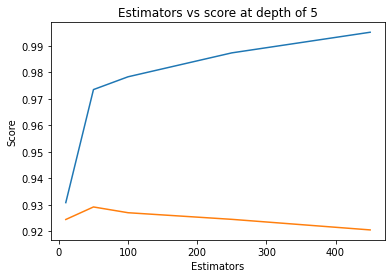

In [24]:
estimators = [10,50,100,250,450]
train_scores = []
test_scores = []
for i in estimators:
    clf = xgb.XGBClassifier(max_depth=5, learning_rate=0.01, n_estimators=i, verbosity=1,
                              silent=None, objective='binary:logistic', booster='gbtree', n_jobs=-1,
                              nthread=None, random_state=25, seed=None, missing=None)
    clf.fit(df_final_train,y_train)
    train_sc = f1_score(y_train,clf.predict(df_final_train))
    test_sc = f1_score(y_test,clf.predict(df_final_test))
    test_scores.append(test_sc)
    train_scores.append(train_sc)
    print('Estimators = ',i,'Train Score',train_sc,'test Score',test_sc)
plt.plot(estimators,train_scores,label='Train Score')
plt.plot(estimators,test_scores,label='Test Score')
plt.xlabel('Estimators')
plt.ylabel('Score')
plt.title('Estimators vs score at depth of 5')

depth =  3 Train Score 0.9235563781018327 test Score 0.9139856678645979
depth =  9 Train Score 0.9763455744646201 test Score 0.9333814078771554
depth =  11 Train Score 0.9808993558612561 test Score 0.9325322690217391
depth =  15 Train Score 0.9897576413253388 test Score 0.9319473907509547
depth =  20 Train Score 0.9954109051385787 test Score 0.9316114256632102
depth =  35 Train Score 0.996360126289541 test Score 0.9318008312833999
depth =  50 Train Score 0.996360126289541 test Score 0.9318008312833999
depth =  70 Train Score 0.996360126289541 test Score 0.9318008312833999
depth =  130 Train Score 0.996360126289541 test Score 0.9318008312833999


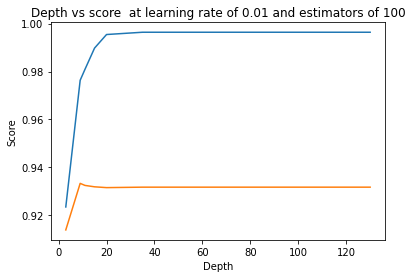

In [28]:
depths = [3,9,11,15,20,35,50,70,130]
train_scores = []
test_scores = []
for i in depths:
    clf = xgb.XGBClassifier(max_depth=i, learning_rate=0.01, n_estimators=100, verbosity=1,
                            silent=None, objective='binary:logistic', booster='gbtree', n_jobs=-1,
                            nthread=None, random_state=25, seed=None, missing=None)

    clf.fit(df_final_train,y_train)
    train_sc = f1_score(y_train,clf.predict(df_final_train))
    test_sc = f1_score(y_test,clf.predict(df_final_test))
    test_scores.append(test_sc)
    train_scores.append(train_sc)
    print('depth = ',i,'Train Score',train_sc,'test Score',test_sc)
plt.plot(depths,train_scores,label='Train Score')
plt.plot(depths,test_scores,label='Test Score')
plt.xlabel('Depth')
plt.ylabel('Score')
plt.title('Depth vs score  at learning rate of 0.01 and estimators of 100')
plt.show()

In [29]:
from sklearn.metrics import f1_score
from sklearn.metrics import f1_score
from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import randint as sp_randint
from scipy.stats import uniform

param_dist = {"n_estimators":sp_randint(45,95),
              "max_depth": sp_randint(3, 9)}

clf = xgb.XGBClassifier(random_state=25, n_jobs=-1, learning_rate=0.01)

rf_random = RandomizedSearchCV(clf, param_distributions=param_dist,
                               n_iter=5,cv=10,scoring='f1',random_state=25,return_train_score=True)

rf_random.fit(df_final_train,y_train)
print('mean test scores',rf_random.cv_results_['mean_test_score'])
print('mean train scores',rf_random.cv_results_['mean_train_score'])

mean test scores [0.9680833  0.97235808 0.96781726 0.96741116 0.92192018]
mean train scores [0.96894103 0.97356998 0.96835226 0.96798712 0.92215054]


In [30]:
print(rf_random.best_estimator_)

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
              importance_type='gain', interaction_constraints='',
              learning_rate=0.01, max_delta_step=0, max_depth=8,
              min_child_weight=1, missing=nan, monotone_constraints='()',
              n_estimators=68, n_jobs=-1, num_parallel_tree=1,
              objective='binary:logistic', random_state=25, reg_alpha=0,
              reg_lambda=1, scale_pos_weight=1, subsample=1,
              tree_method='exact', validate_parameters=1, verbosity=None)


In [31]:
clf = xgb.XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
                        colsample_bynode=1, colsample_bytree=1, gamma=0,
                        learning_rate=0.01, max_delta_step=0, max_depth=8,
                        min_child_weight=1, missing=None, n_estimators=68, n_jobs=-1,
                        nthread=None, objective='binary:logistic', random_state=25,
                        reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
                        silent=None, subsample=1, verbosity=1)

In [32]:
clf.fit(df_final_train,y_train)
y_train_pred = clf.predict(df_final_train)
y_test_pred = clf.predict(df_final_test)

In [33]:
from sklearn.metrics import f1_score
print('Train f1 score',f1_score(y_train,y_train_pred))
print('Test f1 score',f1_score(y_test,y_test_pred))

Train f1 score 0.9734173466365743
Test f1 score 0.9309375798347952


In [34]:
from sklearn.metrics import confusion_matrix
def plot_confusion_matrix(test_y, predict_y):
    C = confusion_matrix(test_y, predict_y)
    
    A =(((C.T)/(C.sum(axis=1))).T)
    
    B =(C/C.sum(axis=0))
    plt.figure(figsize=(20,4))
    
    labels = [0,1]
    # representing A in heatmap format
    cmap=sns.light_palette("blue")
    plt.subplot(1, 3, 1)
    sns.heatmap(C, annot=True, cmap=cmap, fmt=".3f", xticklabels=labels, yticklabels=labels)
    plt.xlabel('Predicted Class')
    plt.ylabel('Original Class')
    plt.title("Confusion matrix")
    
    plt.subplot(1, 3, 2)
    sns.heatmap(B, annot=True, cmap=cmap, fmt=".3f", xticklabels=labels, yticklabels=labels)
    plt.xlabel('Predicted Class')
    plt.ylabel('Original Class')
    plt.title("Precision matrix")
    
    plt.subplot(1, 3, 3)
    # representing B in heatmap format
    sns.heatmap(A, annot=True, cmap=cmap, fmt=".3f", xticklabels=labels, yticklabels=labels)
    plt.xlabel('Predicted Class')
    plt.ylabel('Original Class')
    plt.title("Recall matrix")
    
    plt.show()

Train confusion_matrix


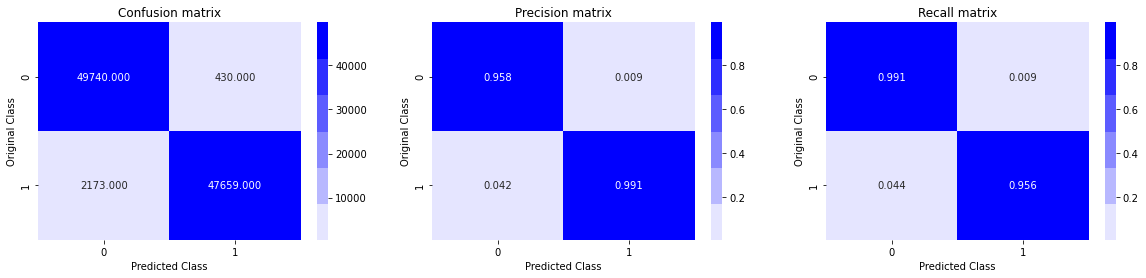

Test confusion_matrix


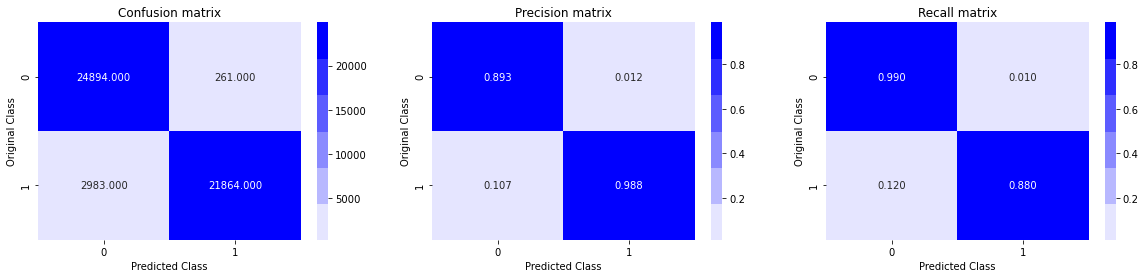

In [35]:
print('Train confusion_matrix')
plot_confusion_matrix(y_train,y_train_pred)
print('Test confusion_matrix')
plot_confusion_matrix(y_test,y_test_pred)

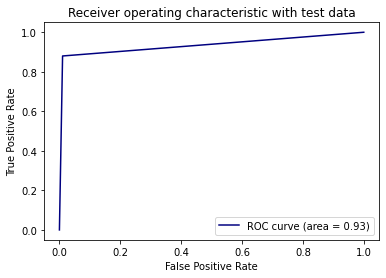

In [36]:
from sklearn.metrics import roc_curve, auc
fpr,tpr,ths = roc_curve(y_test,y_test_pred)
auc_sc = auc(fpr, tpr)
plt.plot(fpr, tpr, color='navy',label='ROC curve (area = %0.2f)' % auc_sc)
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic with test data')
plt.legend()
plt.show()

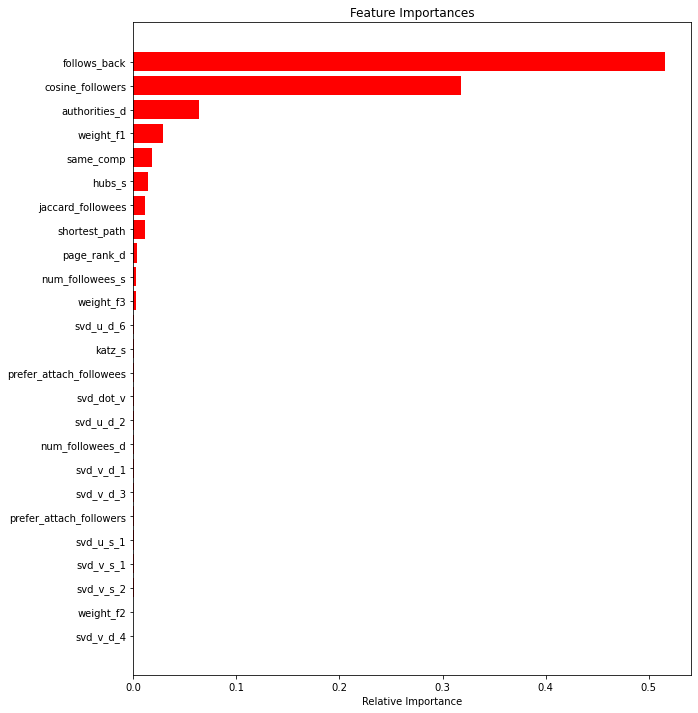

In [37]:
features = df_final_train.columns
importances = clf.feature_importances_
indices = (np.argsort(importances))[-25:]
plt.figure(figsize=(10,12))
plt.title('Feature Importances')
plt.barh(range(len(indices)), importances[indices], color='r', align='center')
plt.yticks(range(len(indices)), [features[i] for i in indices])
plt.xlabel('Relative Importance')
plt.show()